In [1]:
import pandas as pd
import numpy as np
from finance_byu.summarize import summary
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_feather("data/data_botq_2025.ftr") # Merged data
df.rename(columns={"PERMNO": "permno", "MthCalDt": "date", "MthPrc": "prc", "MthRetx": "ret", "MthVol": "volume", 
                   "ShrOut": "shr", "CUSIP": "cusip", "Ticker": "ticker", "act": "current", "at": "assets", "ch": "cash"}, inplace=True)


In [3]:
df = df.loc[df.PrimaryExch.isin(["Q", "A", "N"])]
df = df.drop_duplicates(["permno", "date"], keep="first")
df.reset_index(drop=True, inplace=True)

In [4]:
df["date"] = pd.to_datetime(df["date"])
df.sort_values(by=["permno", "date"], inplace=True)
df['logret'] = np.log(1 + df['ret'])
df['mom'] = df.groupby('permno')['logret'].apply(lambda x: x.rolling(12, min_periods=12).sum().shift(2)).reset_index(level=0, drop=True)
df['me'] = df['shr'] * df['prc']

In [5]:
df['prclag'] = df.groupby('permno')['prc'].shift()
df['melag'] = df.groupby('permno')['me'].shift()
df["assets"] = df.groupby("permno")["assets"].ffill()
df["current"] = df.groupby("permno")["current"].ffill()
df["cash"] = df.groupby("permno")["cash"].ffill()
# df['cashtoasset'] = df["cash"] / df["assets"]
df['currenttoassetlag'] = (df["current"] / df["assets"]).shift()
df.drop(columns=["cash", "current", "assets"], inplace=True)
df = df.loc[(df.date >= pd.to_datetime("1980-01-31")) & (df.date < pd.to_datetime("2025-01-01"))] # NOTE Time period is set here

dfmom = df.query("mom == mom and prclag >= 5 and melag >= 100").reset_index(drop=True)
dfvolmom = dfmom.copy()
dfmom.sort_values("date")

,permno,date,prc,ret,volume,shr,cusip,ticker,PrimaryExch,UGVKEY,...,popsrc,datafmt,curcd,costat,logret,mom,me,prclag,melag,currenttoassetlag
113503,14752,1981-02-27,48.500,0.000000,4.910000e+04,4675,88261010,TPL,N,10504,...,D,STD,USD,A,0.000000,0.695929,2.267375e+05,48.5000,2.267375e+05,NaN
364370,51617,1981-02-27,51.000,0.032911,3.900000e+05,5592,92552610,VIA,N,13714,...,D,STD,USD,A,0.032381,0.376348,2.851920e+05,49.3750,2.761050e+05,0.303045
440069,64390,1981-02-27,30.875,0.138249,NaN,3445,74331510,PROG,Q,13341,...,D,STD,USD,A,0.129491,0.563198,1.063644e+05,27.1250,9.344562e+04,NaN
364055,51596,1981-02-27,32.750,-0.120805,1.467000e+05,7354,48527810,KNB,N,6310,...,D,STD,USD,A,-0.128749,0.761789,2.408435e+05,37.2500,2.739365e+05,0.234710
440596,64426,1981-02-27,10.250,0.012346,NaN,1345,24550010,DVAL,Q,3842,...,D,STD,USD,A,0.012270,0.045985,1.378625e+04,10.1250,1.361812e+04,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235251,23020,2024-12-31,32.490,-0.190785,3.169453e+06,5250,31609219,FDIG,Q,41160,...,D,STD,USD,A,-0.211691,0.618940,1.705725e+05,40.1500,1.646150e+05,NaN
235230,23017,2024-12-31,14.600,-0.056098,2.341100e+04,500,46090F20,EVMT,Q,38252,...,D,STD,USD,A,-0.057733,-0.168623,7.300000e+03,15.4677,7.733850e+03,NaN
235218,23010,2024-12-31,63.100,-0.002529,1.049507e+06,13887,07782B10,BLTE,Q,34025,...,D,STD,USD,A,-0.002532,0.574247,8.762697e+05,63.2600,8.784916e+05,0.950318
235829,23041,2024-12-31,31.690,-0.148118,8.228630e+05,5437,67079U30,NUTX,Q,35824,...,D,STD,USD,A,-0.160307,-0.331460,1.722985e+05,37.2000,2.022564e+05,0.228121


In [6]:
dfmom["mom_bins"] = dfmom.groupby('date')['mom'].transform(pd.qcut,5,labels=[str(k) for k in range(1, 6)])

In [7]:
# Equal weighted, Momentum:
port = dfmom.groupby(['date','mom_bins'], observed=True)['ret'].mean()
port = port.unstack(level=['mom_bins'])
port['spread'] = port['5'] - port['1']
print('Summary statistics from month to month, mom:')
summary(port).round(4)

Summary statistics from month to month, mom:


mom_bins,1,2,3,4,5,spread
count,527.0000,527.0000,527.0000,527.0000,527.0000,527.0000
mean,0.0062,0.0069,0.0088,0.0102,0.0140,0.0077
std,0.0609,0.0437,0.0403,0.0423,0.0572,0.0440
tstat,2.3469,3.6407,5.0062,5.5616,5.6044,4.0405
pval,0.0193,0.0003,0.0000,0.0000,0.0000,0.0001
min,-0.2646,-0.2385,-0.2605,-0.2793,-0.3093,-0.2638
25%,-0.0257,-0.0146,-0.0115,-0.0118,-0.0159,-0.0119
50%,0.0065,0.0084,0.0124,0.0136,0.0172,0.0127
75%,0.0354,0.0307,0.0327,0.0360,0.0502,0.0310
max,0.3156,0.1814,0.1363,0.1336,0.2495,0.2564


In [8]:
# Value weighted, Momentum:
dfmom['weights'] = dfmom.groupby(['date','mom_bins'], observed=True)['melag'].transform(lambda x: x / x.sum())
dfmom['valueReturns'] = dfmom['ret'] * dfmom['weights']
port = dfmom.groupby(['date','mom_bins'], observed=True)['valueReturns'].sum()
port = port.unstack(level=['mom_bins'])
port['spread'] = port['5'] - port['1']
print('Summary statistics from month to month, mom:')
summary(port).round(4)

Summary statistics from month to month, mom:


mom_bins,1,2,3,4,5,spread
count,527.0000,527.0000,527.0000,527.0000,527.0000,527.0000
mean,0.0067,0.0070,0.0078,0.0088,0.0115,0.0049
std,0.0632,0.0467,0.0424,0.0428,0.0528,0.0558
tstat,2.4159,3.4409,4.2228,4.7335,5.0056,1.9965
pval,0.0160,0.0006,0.0000,0.0000,0.0000,0.0464
min,-0.2666,-0.2038,-0.2240,-0.2176,-0.2626,-0.2982
25%,-0.0260,-0.0189,-0.0158,-0.0181,-0.0157,-0.0215
50%,0.0043,0.0089,0.0108,0.0118,0.0160,0.0111
75%,0.0408,0.0321,0.0327,0.0354,0.0443,0.0358
max,0.3018,0.1755,0.1621,0.1488,0.1943,0.2155


In [9]:
bmk = dfmom
bmk['weights'] = bmk.groupby(['date'])['melag'].transform(lambda x: x / x.sum())
bmk['valueReturns'] = bmk['ret'] * bmk['weights']
bmk = bmk.groupby(['date'])['valueReturns'].sum()
bmk

date
1981-02-27    0.024708
1981-03-31    0.029020
1981-04-30   -0.002135
1981-05-29    0.004932
1981-06-30   -0.014482
                ...   
2024-08-30    0.021055
2024-09-30    0.020887
2024-10-31   -0.009700
2024-11-29    0.064375
2024-12-31   -0.033736
Name: valueReturns, Length: 527, dtype: float64

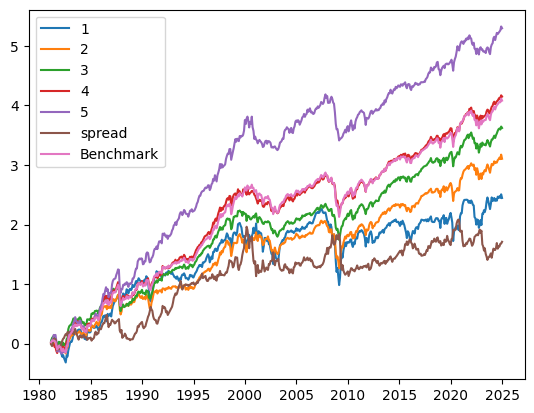

In [10]:
for label in ["1", "2", "3", "4", "5", "spread"]:
    plt.plot(port.index, np.log((port[label] + 1).cumprod()), label=label)
plt.plot(bmk.index, np.log((bmk + 1).cumprod()), label="Benchmark")
plt.legend()
plt.show()

WE ARE ATTEMPTING TO MAKE HSTORY WITH **VOLMOM**

In [11]:
dfvolmom['bins'] = dfvolmom.groupby('date')['mom'].transform(pd.qcut,5,labels=[str(k) for k in range(1, 6)])

port = dfvolmom.groupby(['date','bins'], observed=True)['ret'].mean()
port = port.unstack(level='bins')
print('Summary statistics from month to month:')
summary(port).round(4)


Summary statistics from month to month:


bins,1,2,3,4,5
count,527.0000,527.0000,527.0000,527.0000,527.0000
mean,0.0062,0.0069,0.0088,0.0102,0.0140
std,0.0609,0.0437,0.0403,0.0423,0.0572
tstat,2.3469,3.6407,5.0062,5.5616,5.6044
pval,0.0193,0.0003,0.0000,0.0000,0.0000
min,-0.2646,-0.2385,-0.2605,-0.2793,-0.3093
25%,-0.0257,-0.0146,-0.0115,-0.0118,-0.0159
50%,0.0065,0.0084,0.0124,0.0136,0.0172
75%,0.0354,0.0307,0.0327,0.0360,0.0502
max,0.3156,0.1814,0.1363,0.1336,0.2495


In [12]:
port = dfvolmom.groupby(['date','bins'], observed=True)['permno'].count()
port = port.unstack(level='bins')
print('Average number of stocks in each portfolio each month:')
summary(port).round(4).iloc[1]

Average number of stocks in each portfolio each month:


bins
1    378.7476
2    378.1347
3    378.1404
4    378.1347
5    378.5579
Name: mean, dtype: float64

In [13]:
port = dfvolmom.groupby(['date','bins'], observed=True)['ret'].mean()
port = port.unstack(level='bins')
port["Spread"] = port['5'] - port['1']
print('Summary statistics from month to month:')
summary(port).round(4)

Summary statistics from month to month:


bins,1,2,3,4,5,Spread
count,527.0000,527.0000,527.0000,527.0000,527.0000,527.0000
mean,0.0062,0.0069,0.0088,0.0102,0.0140,0.0077
std,0.0609,0.0437,0.0403,0.0423,0.0572,0.0440
tstat,2.3469,3.6407,5.0062,5.5616,5.6044,4.0405
pval,0.0193,0.0003,0.0000,0.0000,0.0000,0.0001
min,-0.2646,-0.2385,-0.2605,-0.2793,-0.3093,-0.2638
25%,-0.0257,-0.0146,-0.0115,-0.0118,-0.0159,-0.0119
50%,0.0065,0.0084,0.0124,0.0136,0.0172,0.0127
75%,0.0354,0.0307,0.0327,0.0360,0.0502,0.0310
max,0.3156,0.1814,0.1363,0.1336,0.2495,0.2564


In [14]:
# --- Parameters (match/adjust to the paper) ---
lambda_ewma = 0.94           # EWMA decay (common finance choice; paper uses realized variance smoothing)
vol_shift = 1                # use past info only: variance estimate at t uses returns up to t-1
min_var = 1e-8               # floor on variance to avoid blow-ups
rf_monthly = 0.0002          # monthly risk-free (adjust if you have exact rf)
months_per_year = 12

In [15]:
def ewma_var(series, span=None, alpha=None):
    # compute EWMA variance of a returns series (uses .ewm on squared returns)
    # Accept either span or alpha. If span provided, pandas adjusts alpha = 2/(span+1)
    if span is not None:
        return (series.pow(2).ewm(span=span, adjust=False).mean())
    if alpha is not None:
        return (series.pow(2).ewm(alpha=alpha, adjust=False).mean())
    return (series.pow(2).ewm(alpha=1-lambda_ewma, adjust=False).mean())

# --- 0) basic factor series: momentum spread (winners - losers) ---
# assumes port[4] and port[0] exist and are the factor returns (value-weighted)
spread = port['5'] - port['1']
spread = spread.sort_index()

# --- 1) Portfolio-level Moreira & Muir style scaling ---
# 1a) estimate conditional variance using EWMA on past spread returns
# shift so sigma_hat_t uses information up to t-1
spread_for_var = spread.shift(1)         # returns observed up to t-1
# choose EWMA span roughly equivalent to monthly persistence used by practitioners (tune if desired)
span_months = 12                         # 12-month effective memory; change to 3/6/12 per experiments
sigma2_hat = ewma_var(spread_for_var, span=span_months).clip(lower=min_var)   # variance estimate
sigma_hat = np.sqrt(sigma2_hat) # Get std

# 1b) raw managed factor: spread / sigma_hat (paper uses inverse variance; using std in discrete time)
raw_vm = spread / sigma_hat

# 1c) choose constant c to match unconditional std of managed series to original spread (paper's normalizing c)
# compute c such that std(c * raw_vm) == std(spread) -> c = std(spread) / std(raw_vm)
std_spread = spread.dropna().std()
std_raw_vm = raw_vm.dropna().std()
c = std_spread / (std_raw_vm if std_raw_vm > 0 else 1.0)
vm_portfolio = (c * raw_vm).dropna()

# 1d) Sharpe stats (monthly and annualized)
def sharpe(series, rf=0.0, annualize=True):
    s = (series.mean() - rf) / series.std()
    if annualize:
        return s * np.sqrt(months_per_year)
    return s

sharpe_spread_monthly = (spread.mean() - rf_monthly) / spread.std()
sharpe_vm_port_monthly = (vm_portfolio.mean() - rf_monthly) / vm_portfolio.std()
sharpe_spread_annual = sharpe(spread, rf_monthly, annualize=True)
sharpe_vm_port_annual = sharpe(vm_portfolio, rf_monthly, annualize=True)

print("Portfolio-level M&M replication (EWMA var, span_months={}):".format(span_months))
print(f"  c (normalizer) = {c:.4f}")
print(f"  Regular spread Sharpe (monthly) = {sharpe_spread_monthly:.4f}; annualized = {sharpe_spread_annual:.4f}")
print(f"  VM portfolio Sharpe (monthly) = {sharpe_vm_port_monthly:.4f}; annualized = {sharpe_vm_port_annual:.4f}")
print("  sample start/end:", spread.dropna().index.min(), spread.dropna().index.max())
print("  n months (spread):", spread.dropna().shape[0])
print()

# --- 2) Leg-level M&M variant (scale legs separately then net, then normalize by c_leg) ---
# Build leg returns aligned to port index. Use value-weighted returns if available in df; otherwise use port columns mean.
# Try to extract leg-level returns from port (port[0], port[4]) which are value-weighted means already.
wins = port['5'].sort_index()
loss = port['1'].sort_index()

# estimate EWMA variances for each leg using past returns (shifted)
wins_var_hat = ewma_var(wins.shift(1), span=span_months).clip(lower=min_var)
loss_var_hat = ewma_var(loss.shift(1), span=span_months).clip(lower=min_var)
wins_sigma = np.sqrt(wins_var_hat)
loss_sigma = np.sqrt(loss_var_hat)

# raw leg-managed returns: r_leg / sigma_leg
wins_raw = wins / wins_sigma
loss_raw = loss / loss_sigma

# leg-level net raw managed spread and then normalize with c_leg to match spread unconditional std
leg_raw_spread = (wins_raw - loss_raw).dropna()
std_leg_raw = leg_raw_spread.std()
c_leg = std_spread / (std_leg_raw if std_leg_raw > 0 else 1.0)
vm_leg = (c_leg * leg_raw_spread).dropna()

sharpe_vm_leg_monthly = (vm_leg.mean() - rf_monthly) / vm_leg.std()
sharpe_vm_leg_annual = sharpe(vm_leg, rf_monthly, annualize=True)

print("Leg-level M&M replication (EWMA var per leg):")
print(f"  c_leg (normalizer) = {c_leg:.4f}")
print(f"  Leg-level VM Sharpe (monthly) = {sharpe_vm_leg_monthly:.4f}; annualized = {sharpe_vm_leg_annual:.4f}")
print()

# --- 3) Diagnostics and quick checks ---
diag = pd.DataFrame({
    'spread': spread,
    'sigma_hat': sigma_hat,
    'raw_vm': raw_vm,
    'vm_portfolio': vm_portfolio,
    'wins': wins,
    'wins_sigma': wins_sigma,
    'wins_raw': wins_raw,
    'loss': loss,
    'loss_sigma': loss_sigma,
    'loss_raw': loss_raw,
    'vm_leg': vm_leg
})
# keep only aligned indices
diag = diag.loc[spread.index].copy()

print("Scale diagnostics (describe):")
print("  spread sigma_hat describe:\n", sigma_hat.dropna().describe().round(6))
print("  c and c_leg:", round(c,4), round(c_leg,4))
print()
# Show top extreme scale months for vm_portfolio
scales = (1.0 / sigma_hat).dropna()
print("Scale (1/sigma_hat) summary (portfolio-level):\n", scales.describe().round(4))
print("Counts of months with extreme scale > 3 or < 0.33:", ((scales>3).sum(), (scales<0.33).sum()))


Portfolio-level M&M replication (EWMA var, span_months=12):
  c (normalizer) = 0.0407
  Regular spread Sharpe (monthly) = 0.1715; annualized = 0.5940
  VM portfolio Sharpe (monthly) = 0.2456; annualized = 0.8507
  sample start/end: 1981-02-27 00:00:00 2024-12-31 00:00:00
  n months (spread): 527

Leg-level M&M replication (EWMA var per leg):
  c_leg (normalizer) = 0.0491
  Leg-level VM Sharpe (monthly) = 0.2297; annualized = 0.7956

Scale diagnostics (describe):
  spread sigma_hat describe:
 count    526.000000
mean       0.040236
std        0.019234
min        0.015473
25%        0.028608
50%        0.034919
75%        0.044357
max        0.127649
dtype: float64
  c and c_leg: 0.0407 0.0491

Scale (1/sigma_hat) summary (portfolio-level):
 count    526.0000
mean      29.0366
std       10.3439
min        7.8340
25%       22.5445
50%       28.6377
75%       34.9550
max       64.6282
dtype: float64
Counts of months with extreme scale > 3 or < 0.33: (np.int64(526), np.int64(0))


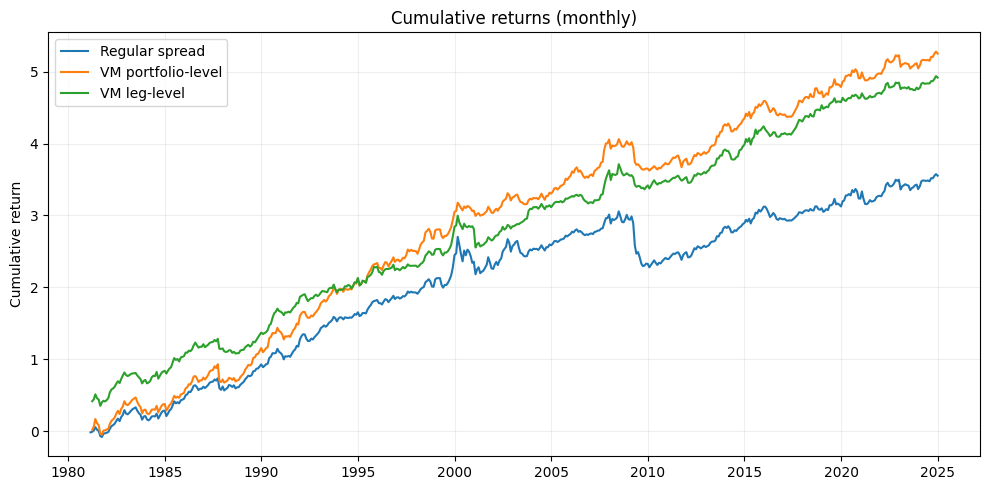

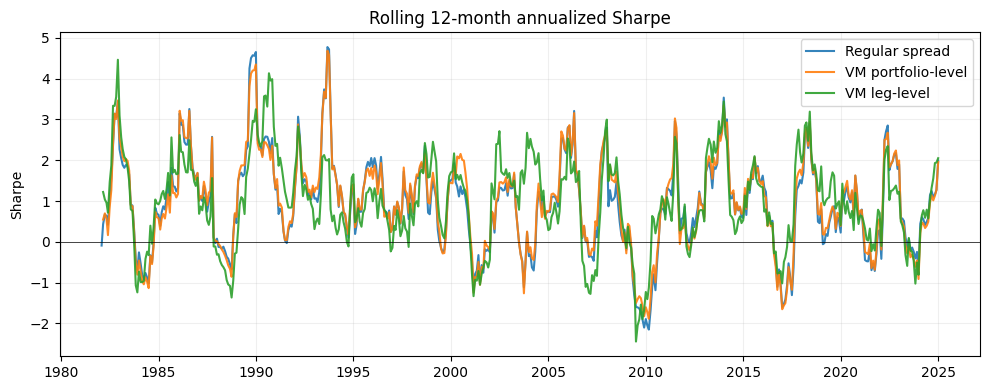

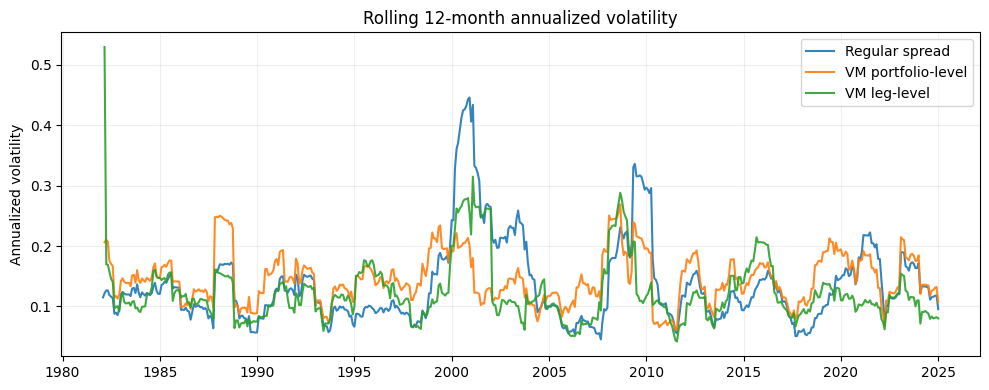

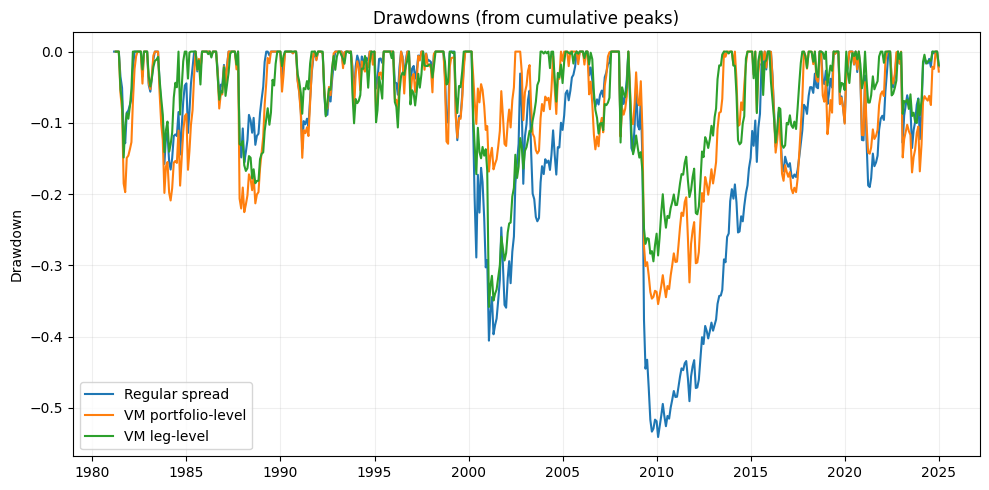

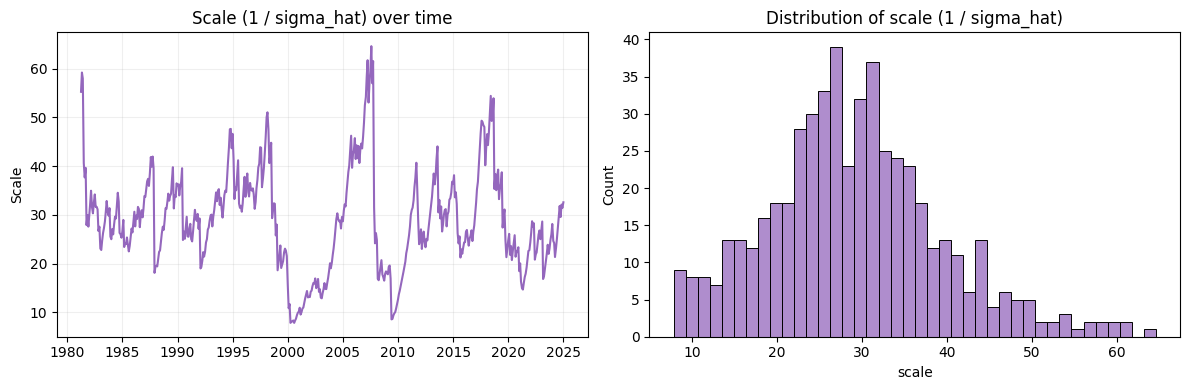

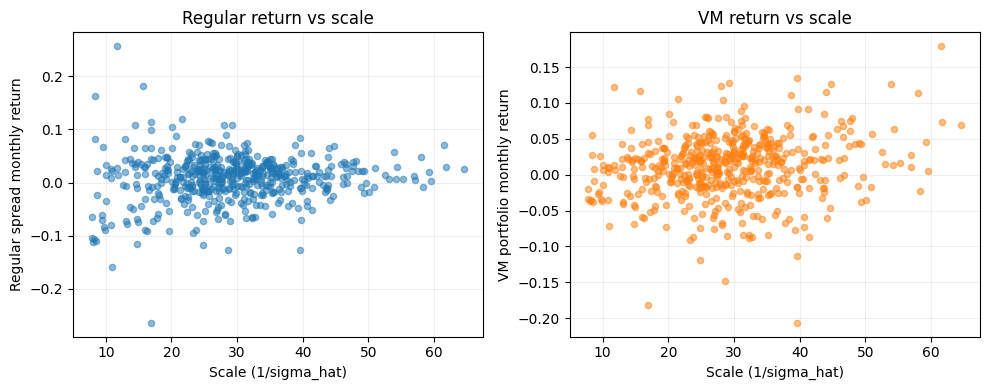

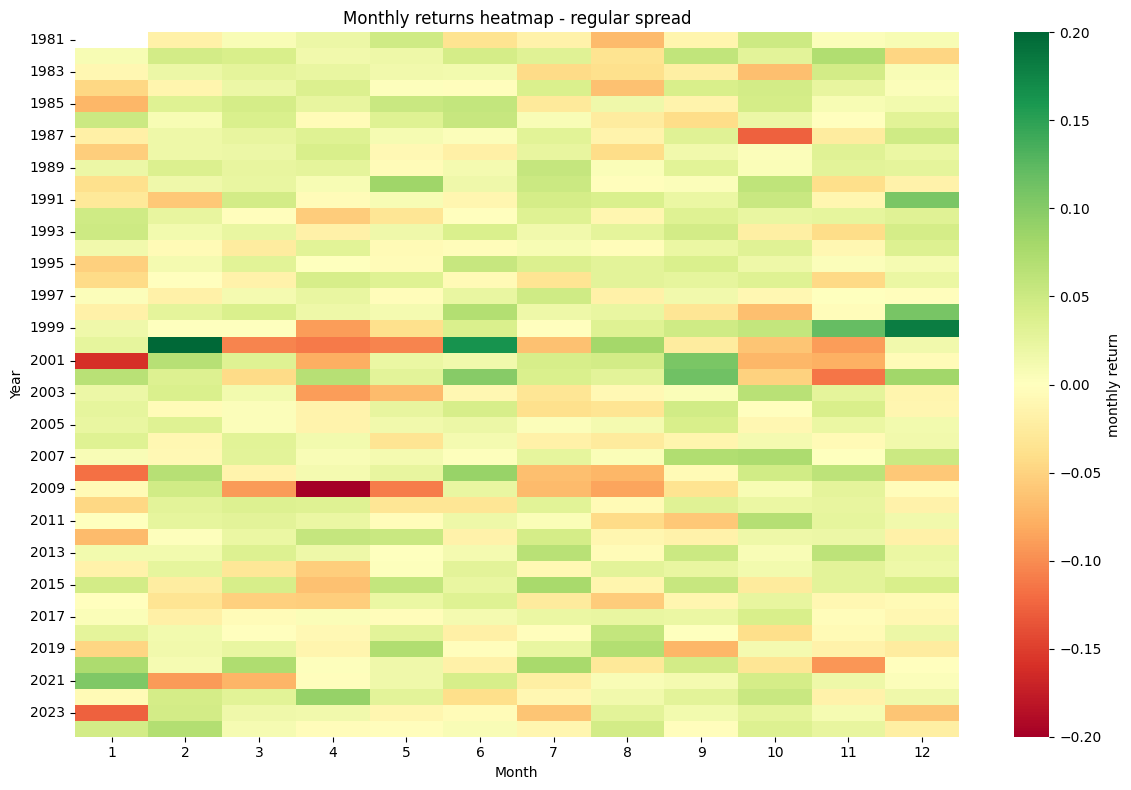

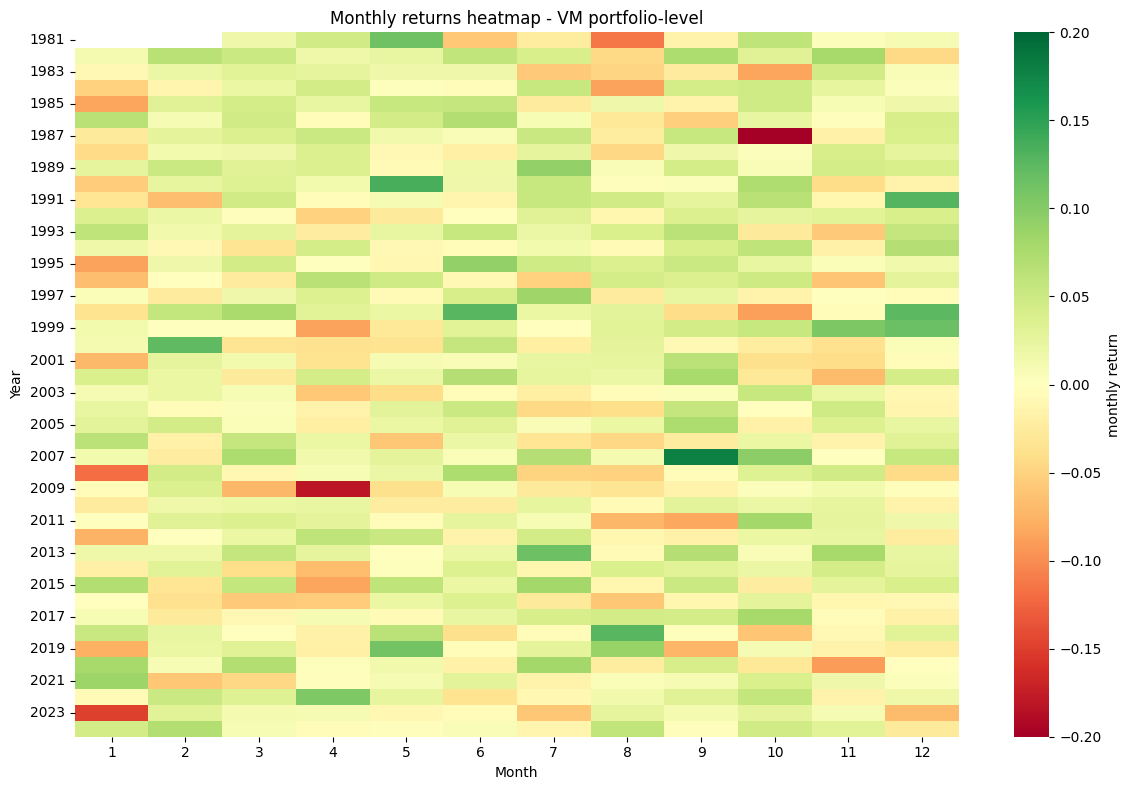

              ann_mean  ann_vol  ann_sharpe  max_drawdown
regular         0.0929   0.1524      0.6097       -0.5408
vm_portfolio    0.1320   0.1524      0.8664       -0.3543
vm_leg          0.1236   0.1524      0.8114       -0.3583


In [16]:
# Plots for comparing regular vs volatility-managed momentum
# Ensure expected series exist

for name in ['spread','vm_portfolio','vm_leg','sigma_hat']:
    if name not in globals():
        raise RuntimeError(f"Required series '{name}' not found in the notebook namespace.")

# Align series and drop NaNs for plotting comparisons
data = pd.DataFrame({
    'spread': spread,
    'vm_portfolio': vm_portfolio,
    'vm_leg': vm_leg,
    'scale': (1.0 / sigma_hat).replace([np.inf, -np.inf], np.nan)
}).dropna(how='all').sort_index()

# Helper transforms
monthly_to_annual = np.sqrt(12)
def ann_mean(sr): return sr.mean() * 12
def ann_vol(sr): return sr.std() * monthly_to_annual
def rolling_ann_sharpe(sr, window=12, rf=0.0002):
    roll_mean = sr.rolling(window).mean() * 12
    roll_std = sr.rolling(window).std() * monthly_to_annual
    return (roll_mean - rf*12) / roll_std

# 1) Cumulative returns (line)
cum = (1 + data[['spread','vm_portfolio','vm_leg']]).cumprod() - 1
plt.figure(figsize=(10,5))
plt.plot(cum.index, np.log1p(cum['spread']), label='Regular spread', linewidth=1.5)
plt.plot(cum.index, np.log1p(cum['vm_portfolio']), label='VM portfolio-level', linewidth=1.5)
plt.plot(cum.index, np.log1p(cum['vm_leg']), label='VM leg-level', linewidth=1.5)
plt.legend()
plt.title('Cumulative returns (monthly)')
plt.ylabel('Cumulative return')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('figures/cumulative_returns.png', dpi=300, bbox_inches='tight')
plt.show()

# 2) Rolling annualized Sharpe (12-month)
plt.figure(figsize=(10,4))
rs_sp = rolling_ann_sharpe(data['spread'])
rs_vm = rolling_ann_sharpe(data['vm_portfolio'])
rs_leg = rolling_ann_sharpe(data['vm_leg'])
plt.plot(rs_sp.index, rs_sp, label='Regular spread', alpha=0.9)
plt.plot(rs_vm.index, rs_vm, label='VM portfolio-level', alpha=0.9)
plt.plot(rs_leg.index, rs_leg, label='VM leg-level', alpha=0.9)
plt.axhline(0, color='k', linewidth=0.5)
plt.legend()
plt.title('Rolling 12-month annualized Sharpe')
plt.ylabel('Sharpe')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('figures/rolling_sharpe.png', dpi=300, bbox_inches='tight')
plt.show()

# 3) Rolling annualized volatility (12-month)
plt.figure(figsize=(10,4))
rv_sp = data['spread'].rolling(12).std() * monthly_to_annual
rv_vm = data['vm_portfolio'].rolling(12).std() * monthly_to_annual
rv_leg = data['vm_leg'].rolling(12).std() * monthly_to_annual
plt.plot(rv_sp.index, rv_sp, label='Regular spread', alpha=0.9)
plt.plot(rv_vm.index, rv_vm, label='VM portfolio-level', alpha=0.9)
plt.plot(rv_leg.index, rv_leg, label='VM leg-level', alpha=0.9)
plt.legend()
plt.title('Rolling 12-month annualized volatility')
plt.ylabel('Annualized volatility')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('figures/rolling_volatility.png', dpi=300, bbox_inches='tight')
plt.show()

# 4) Maximum drawdown curves
def drawdown(series):
    cum = (1+series).cumprod()
    peak = cum.cummax()
    dd = (cum / peak) - 1
    return dd
dd_sp = drawdown(data['spread'])
dd_vm = drawdown(data['vm_portfolio'])
dd_leg = drawdown(data['vm_leg'])
plt.figure(figsize=(10,5))
plt.plot(dd_sp.index, dd_sp, label='Regular spread')
plt.plot(dd_vm.index, dd_vm, label='VM portfolio-level')
plt.plot(dd_leg.index, dd_leg, label='VM leg-level')
plt.legend()
plt.title('Drawdowns (from cumulative peaks)')
plt.ylabel('Drawdown')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('figures/drawdowns.png', dpi=300, bbox_inches='tight')
plt.show()

# 5) Scale time series (1/sigma_hat) and its histogram
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(data['scale'].index, data['scale'], color='tab:purple')
axs[0].set_title('Scale (1 / sigma_hat) over time')
axs[0].set_ylabel('Scale')
axs[0].grid(alpha=0.2)
sns.histplot(data['scale'].dropna(), bins=40, ax=axs[1], color='tab:purple')
axs[1].set_title('Distribution of scale (1 / sigma_hat)')
plt.tight_layout()
plt.savefig('figures/scale_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 6) Scatter: monthly returns vs scale for portfolio-level VM and regular spread
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(data['scale'], data['spread'], alpha=0.5, s=20)
plt.xlabel('Scale (1/sigma_hat)')
plt.ylabel('Regular spread monthly return')
plt.title('Regular return vs scale')
plt.grid(alpha=0.2)

plt.subplot(1,2,2)
plt.scatter(data['scale'], data['vm_portfolio'], alpha=0.5, s=20, color='tab:orange')
plt.xlabel('Scale (1/sigma_hat)')
plt.ylabel('VM portfolio monthly return')
plt.title('VM return vs scale')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('figures/returns_vs_scale.png', dpi=300, bbox_inches='tight')
plt.show()

# 7) Monthly heatmap of returns (years on y, months on x) for quick seasonal/time visualization
def monthly_heatmap(series, title, filename):
    s = series.dropna().copy()
    s = s.to_frame('r')
    s['year'] = s.index.year
    s['month'] = s.index.month
    pivot = s.pivot_table(index='year', columns='month', values='r', aggfunc='mean')
    plt.figure(figsize=(12,8))
    sns.heatmap(pivot, cmap='RdYlGn', center=0, vmin=-0.2, vmax=0.2, cbar_kws={'label':'monthly return'})
    plt.title(title)
    plt.ylabel('Year')
    plt.xlabel('Month')
    plt.tight_layout()
    plt.savefig(f'figures/{filename}', dpi=300, bbox_inches='tight')
    plt.show()

monthly_heatmap(data['spread'], 'Monthly returns heatmap - regular spread', 'heatmap_regular_spread.png')
monthly_heatmap(data['vm_portfolio'], 'Monthly returns heatmap - VM portfolio-level', 'heatmap_vm_portfolio.png')

# 8) Summary table printed: annualized mean, vol, Sharpe, max drawdown
summary = pd.DataFrame(index=['regular','vm_portfolio','vm_leg'])
summary['ann_mean'] = [ann_mean(data['spread'].dropna()), ann_mean(data['vm_portfolio'].dropna()), ann_mean(data['vm_leg'].dropna())]
summary['ann_vol'] = [ann_vol(data['spread'].dropna()), ann_vol(data['vm_portfolio'].dropna()), ann_vol(data['vm_leg'].dropna())]
summary['ann_sharpe'] = summary['ann_mean'] / summary['ann_vol']
summary['max_drawdown'] = [dd_sp.min(), dd_vm.min(), dd_leg.min()]
print(summary.round(4))
